In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import matplotlib.dates as mdates

# Define Eastern timezone
eastern = pytz.timezone('US/Eastern')

In [13]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load candlestick data
df = pd.read_csv("../data/price_data.csv", parse_dates=["time"])
df.sort_values("time", inplace=True)

# Replace 0 in ema10/ema30 with NaN
df.loc[df['ema10'] == 0, 'ema10'] = float('nan')
df.loc[df['ema30'] == 0, 'ema30'] = float('nan')

# Load trade data
trades = pd.read_csv("../data/trades.csv", parse_dates=["time"])

# Split buy and sell trades
buy_trades = trades[trades['side'].str.lower() == 'buy']
sell_trades = trades[trades['side'].str.lower() == 'sell']

# Create subplot figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

# Candlestick chart
fig.add_trace(
    go.Candlestick(
        x=df['time'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        increasing_line_color='green',
        decreasing_line_color='red',
        name='Candlesticks'
    )
)

# EMA10 line
fig.add_trace(
    go.Scatter(
        x=df['time'],
        y=df['ema10'],
        mode='lines',
        name='EMA10',
        line=dict(color='blue')
    )
)

# EMA30 line
fig.add_trace(
    go.Scatter(
        x=df['time'],
        y=df['ema30'],
        mode='lines',
        name='EMA30',
        line=dict(color='red')
    )
)

# Buy trade markers
fig.add_trace(
    go.Scatter(
        x=buy_trades['time'],
        y=buy_trades['price'],
        mode='markers',
        marker=dict(symbol='triangle-up', size=12, color='limegreen'),
        name='Buy Trades'
    )
)

# Sell trade markers
fig.add_trace(
    go.Scatter(
        x=sell_trades['time'],
        y=sell_trades['price'],
        mode='markers',
        marker=dict(symbol='triangle-down', size=12, color='deeppink'),
        name='Sell Trades'
    )
)

# Update layout
fig.update_layout(
    title='1-Minute Candlestick Chart with EMA10, EMA30, and Trades',
    xaxis_title='Time',
    yaxis_title='Price',
    width=1600,
    height=800,
    hovermode='x unified',
    xaxis_rangeslider_visible=False
)

# Enable crosshair
fig.update_xaxes(showspikes=True, spikecolor="grey", spikemode="across", spikesnap="cursor", spikethickness=1)
fig.update_yaxes(showspikes=True, spikecolor="grey", spikemode="across", spikesnap="cursor", spikethickness=1)

# Show figure with scroll zoom
fig.show(config={'scrollZoom': True})


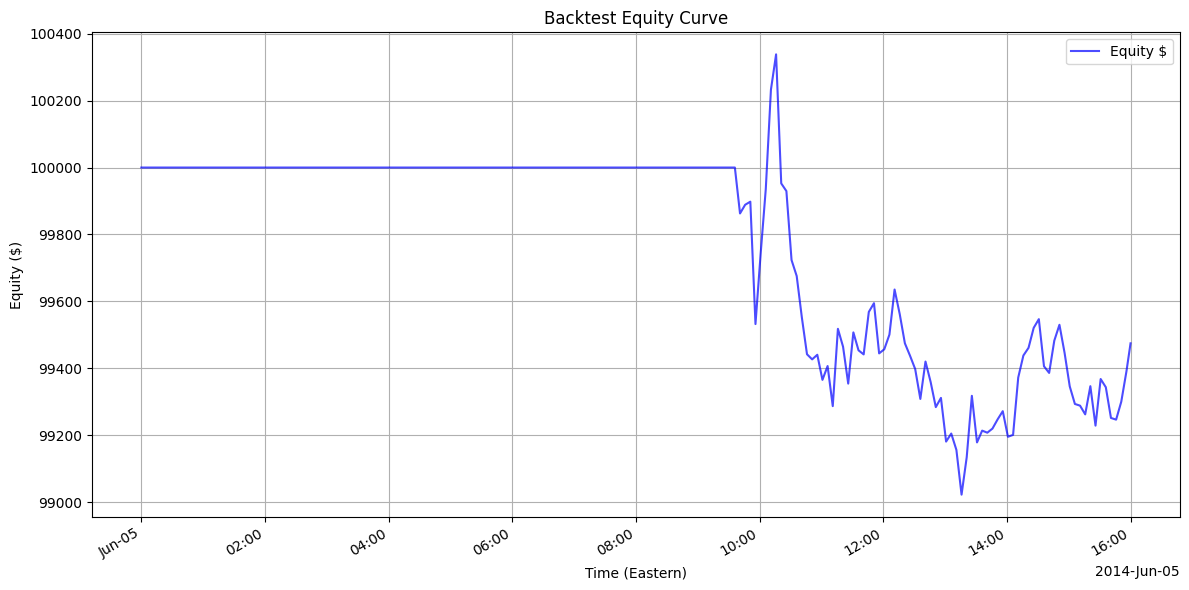

In [10]:
# Load JSON data
filename = "backtests/2025-03-29_20-32-11/1116578219.json"
with open(filename, "r") as f:
    raw_data = json.load(f)

# Extract equity curve
equity_series = raw_data["charts"]["Strategy Equity"]["series"]["Equity"]["values"]

rows = []
for item in equity_series:
    # item = [unixSeconds, open, high, low, close]
    epoch_time, o, h, l, c = item
    dt_et = datetime.fromtimestamp(epoch_time, eastern)
    rows.append((dt_et, o, h, l, c))

df_equity = pd.DataFrame(rows, columns=["time_et", "open", "high", "low", "close"])

# Now df_equity *has* a column named 'time_et'
# print(df_equity.head())
# print(df_equity.columns)

# Sort by time_utc
df_equity.sort_values("time_et", inplace=True)
# Convert timestamp to readable format
df_equity["time_et"] = df_equity["time_et"].dt.tz_localize(None)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_equity["time_et"], df_equity["close"], label="Equity $", color="blue", alpha=0.7)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xlabel("Time (Eastern)")
ax.set_ylabel("Equity ($)")
ax.set_title("Backtest Equity Curve")

fig.autofmt_xdate()  # optional, rotates labels

plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

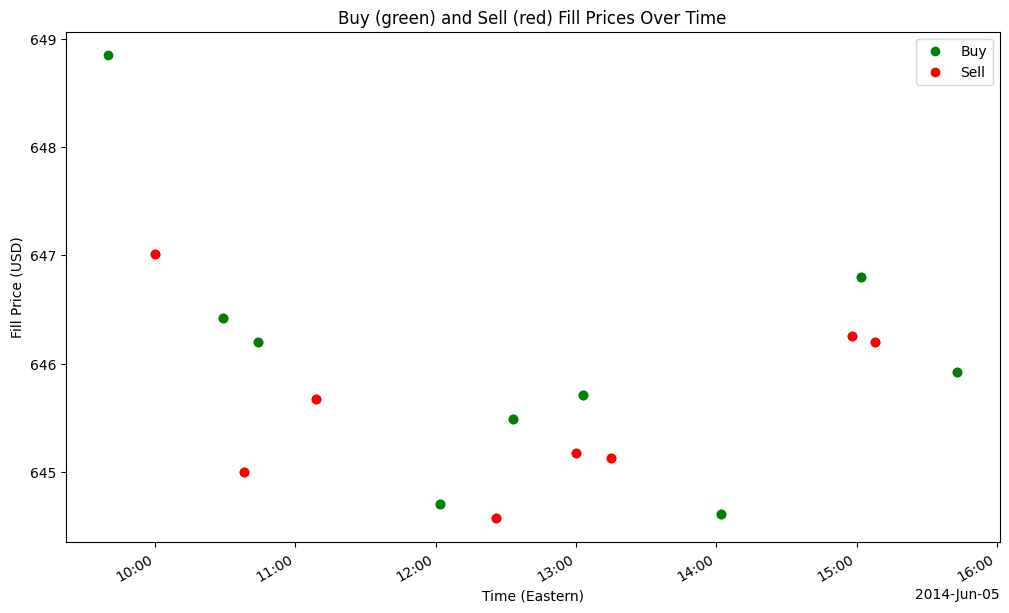

In [6]:
# 1) Load JSON data
filename = "backtests/2025-03-29_20-32-11/1116578219-order-events.json"
with open(filename, "r") as f:
    raw_data = json.load(f)

# 2) Filter for only filled events, then sort by time
filled_events = [e for e in raw_data if e["status"] == "filled"]
filled_events.sort(key=lambda x: x["time"])

# 3) Convert Unix time to Eastern time and build a DataFrame
rows = []
for e in filled_events:
    # Convert Unix timestamp (UTC) to Eastern Time
    dt_et = datetime.fromtimestamp(e["time"], eastern)
    
    rows.append({
        "datetime_et": dt_et,
        "price": e["fillPrice"],
        "direction": e["direction"]
    })

df = pd.DataFrame(rows)
# Convert timestamp to readable format
df["datetime_et"] = df["datetime_et"].dt.tz_localize(None)

# print(df.head())
# print(df.columns)

# 4) Plot a line of fill prices over time
fig, ax = plt.subplots(figsize=(10, 6))

# Line plot for all trades in chronological order
#ax.plot(df["datetime_et"], df["price"], linestyle='-',
        #color='blue', label="Trade Price", alpha=0.5)

# Mark buys (green) and sells (red)
buy_df = df[df["direction"] == "buy"]
sell_df = df[df["direction"] == "sell"]

ax.scatter(buy_df["datetime_et"], buy_df["price"], color='green', marker='o', label="Buy")
ax.scatter(sell_df["datetime_et"], sell_df["price"], color='red', marker='o', label="Sell")

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

# Plot EMA 10 and 30 curves
filename = "backtests/2025-03-29_20-32-11/1116578219.json"
with open(filename, "r") as f:
    raw_data = json.load(f)

# Extract equity curve
ema10_series = raw_data["charts"]["EMA Values"]["series"]["EMA10"]["values"]
ema30_series = raw_data["charts"]["EMA Values"]["series"]["EMA30"]["values"]

rows = []
for item in ema10_series:
    # item = [unixSeconds, value]
    epoch_time, v = item
    dt_et = datetime.fromtimestamp(epoch_time, eastern)
    rows.append((dt_et, v))

df_ema10 = pd.DataFrame(rows, columns=["time_et", "value"])

# Sort by time_utc
df_ema10.sort_values("time_et", inplace=True)
# Convert timestamp to readable format
df_ema10["time_et"] = df_ema10["time_et"].dt.tz_localize(None)

#ax.plot(df_ema10["time_et"], df_ema10["value"], label="EMA 10", color="orange", alpha=0.7)

fig.autofmt_xdate()  # optional, rotates labels
plt.tight_layout()
ax.set_xlabel("Time (Eastern)")
ax.set_ylabel("Fill Price (USD)")
ax.set_title("Buy (green) and Sell (red) Fill Prices Over Time")
ax.legend()

plt.show()